In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import seaborn as sns
import ta
from datetime import datetime as dt
from ta import trend, momentum, volatility
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.utils.vis_utils import plot_model

In [ ]:
high = web.DataReader("^SPX", start='2013-1-1', end='2023-1-1', data_source='stooq')['High']
low = web.DataReader("^SPX", start='2013-1-1', end='2023-1-1', data_source='stooq')['Low']
close = web.DataReader("^SPX", start='2013-1-1', end='2023-1-1', data_source='stooq')['Close']
open = web.DataReader("^SPX", start='2013-1-1', end='2023-1-1', data_source='stooq')['Open']
stopy_procentowe = web.DataReader("EFFR", start='2013-1-1', end='2023-1-1', data_source='fred')
stopa_bezrobocia = web.DataReader("UNRATE", start='2013-1-1', end='2023-1-1', data_source='fred')
sentyment = web.DataReader("UMCSENT", start='2013-1-1', end='2023-1-1', data_source='fred')
dolar = web.DataReader("DTWEXBGS", start='2013-1-1', end='2023-1-1', data_source='fred')
vix = web.DataReader("VIXCLS", start='2013-1-1', end='2023-1-1', data_source='fred')

In [ ]:
# MACD
# Obliczanie 12 okresowej wykładniczej średniej kroczącej
EMA12 = close.ewm(span=12, adjust=False).mean()

# Obliczanie 26 okresowej wykładniczej średniej kroczącej
EMA26 = close.ewm(span=26, adjust=False).mean()

# Obliczanie krzywej MACD
macd = EMA12 - EMA26

In [ ]:
# RSI
rsi = ta.momentum.rsi(close, window=14)

In [ ]:
# ATR
atr = ta.volatility.AverageTrueRange(high=high, low=low, close=close, window=14, fillna=True)
atr = atr.average_true_range()

In [ ]:
# Dostosowanie zmiennych o frekwencji miesięcznej do frekwencji dziennej
def dostosuj_dzienne(x):
  x = x.asfreq('D')
  x = x.reindex(pd.date_range(start='2013-1-1', end='2023-1-1', freq='D'))
  x = x.fillna(method='ffill')
  x_dzienna = x

  return x_dzienna

In [ ]:
# Transformacja zmiennych o frekwencji dziennej - stopa_bezrobocia, sentyment
stopa_bezrobocia = dostosuj_dzienne(stopa_bezrobocia)
sentyment = dostosuj_dzienne(sentyment)

In [ ]:
# Stworzenie ramki danych ze wszystkimi zmiennymi
nazwy_kolumn = ['high', 'low', 'close', 'open', 'stopy_procentowe', 'stopa_bezrobocia',
           'sentyment', 'dolar', 'vix', 'macd', 'rsi', 'atr']
zmienne = [high, low, close, open, stopy_procentowe, stopa_bezrobocia,
           sentyment, dolar, vix, macd, rsi, atr]

# Przygotowanie pustej ramki
df = pd.DataFrame()

# Dodanie zmiennych
for nazwa_kolumny, zmienna in zip(nazwy_kolumn, zmienne):
  df[f'{nazwa_kolumny}'] = zmienna

In [ ]:
# Sprawdzenie brakujących wartości
for col in df.columns:
    print(f"{col}: {df[col].isna().sum()} brakujących wartości")

high: 0 brakujących wartości
low: 0 brakujących wartości
close: 0 brakujących wartości
open: 0 brakujących wartości
stopy_procentowe: 19 brakujących wartości
stopa_bezrobocia: 0 brakujących wartości
sentyment: 0 brakujących wartości
dolar: 42 brakujących wartości
vix: 0 brakujących wartości
macd: 0 brakujących wartości
rsi: 13 brakujących wartości
atr: 0 brakujących wartości


In [ ]:
# Usunięcie brakujących wartości
df = df.dropna(how='any')

In [ ]:
# Sprawdzenie brakujących wartości ponownie
for col in df.columns:
    print(f"{col}: {df[col].isna().sum()} brakujących wartości")

high: 0 brakujących wartości
low: 0 brakujących wartości
close: 0 brakujących wartości
open: 0 brakujących wartości
stopy_procentowe: 0 brakujących wartości
stopa_bezrobocia: 0 brakujących wartości
sentyment: 0 brakujących wartości
dolar: 0 brakujących wartości
vix: 0 brakujących wartości
macd: 0 brakujących wartości
rsi: 0 brakujących wartości
atr: 0 brakujących wartości


In [ ]:
# Do budowy modelu nie będą potrzebne zmienne: high, low, open;
df = df.drop(columns=['high', 'low', 'open'])

<Axes: >

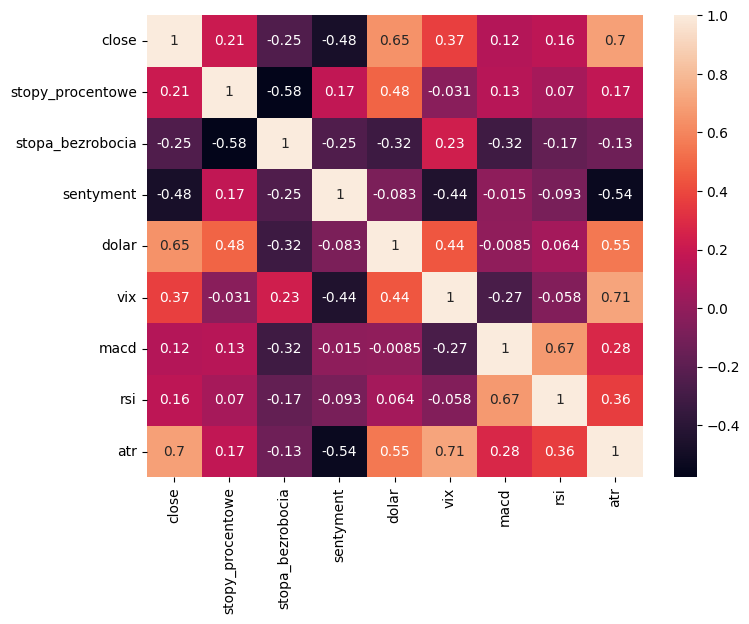

In [ ]:
# Macierz korelacji
corrmat = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corrmat, annot=True)

# Przygotowanie danych do budowy modelu

In [ ]:
# Odwrócenie ramki, ponieważ zaczyna się od ostatniej daty
df = df[::-1]

In [ ]:
# Normalizacja danych przy użyciu MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [ ]:
# Podział zbioru danych na treningowy (80%), walidacyjny (10%) i testowy
train_size = int(len(df_scaled) * 0.8)
val_size = int(len(df_scaled) * 0.1)
train_data = df_scaled[:train_size]
val_data = df_scaled[train_size:train_size+val_size]
test_data = df_scaled[train_size+val_size:]

In [ ]:
# Zdefiniowane kroków czasowych dla LSTM
time_steps = 10

In [ ]:
# Przygotowanie zbiorów treningowego, walidacyjnego i testowego
def przygotuj_zbiory(time_steps, data):

  X, y = [], []

  for i in range(time_steps, len(data)):
    X.append(data[i - time_steps:i, :])
    y.append(data[i, 0])

  X = np.array(X)
  y = np.array(y)

  return X, y

In [ ]:
X_train, y_train = przygotuj_zbiory(time_steps=time_steps, data=train_data)
X_val, y_val = przygotuj_zbiory(time_steps=time_steps, data=val_data)
X_test, y_test = przygotuj_zbiory(time_steps=time_steps, data=test_data)

# Budowa modelu

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), verbose=0,
                    callbacks=[early_stopping])

In [ ]:
y_pred = model.predict(X_test)

8/8 [==============================] - 1s 8ms/step


In [ ]:
y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), df.shape[1]-1))), axis=1))[:, 0]
y_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), df.shape[1]-1))), axis=1))[:, 0]

In [ ]:
mse = np.mean((y_actual - y_pred ) ** 2)
rmse = np.sqrt(np.mean((y_actual - y_pred) ** 2))

In [ ]:
print(mse)

24459.461535480335


In [ ]:
print(rmse)

156.39520943903727


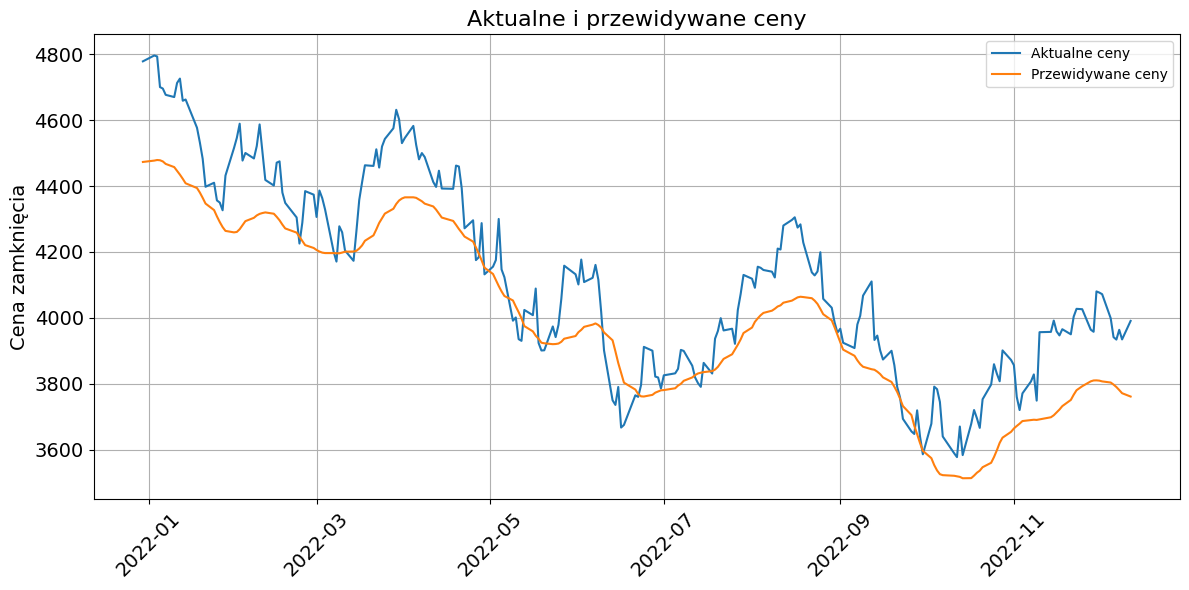

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size+val_size+time_steps:], y_actual, label='Aktualne ceny')
plt.plot(df.index[train_size+val_size+time_steps:], y_pred, label='Przewidywane ceny')
plt.ylabel('Cena zamknięcia', size=14)
plt.title('Aktualne i przewidywane ceny', size=16)
plt.legend()
plt.yticks(size=14)
plt.xticks(size=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 50)            12000     
                                                                 
 dropout_3 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

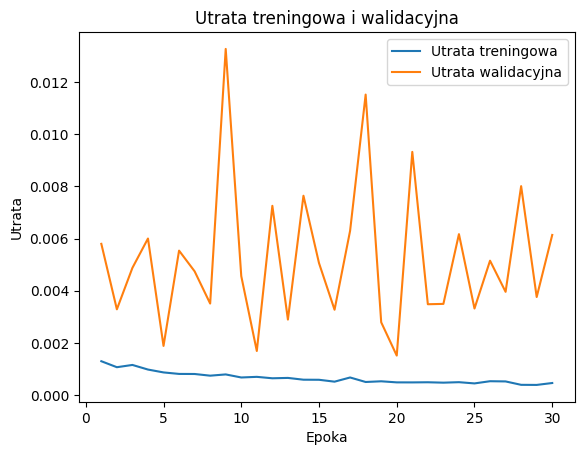

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)


plt.plot(epochs, training_loss, label='Utrata treningowa')
plt.plot(epochs, validation_loss, label='Utrata walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Utrata')
plt.title('Utrata treningowa i walidacyjna')
plt.legend()
plt.show()